# 03. Text Analysis

This notebook performs Natural Language Processing (NLP) and topic modeling on the financial news headlines.

**Sections:**
1. **Keyword and Phrase Extraction** - Common keywords identification and word frequency analysis
2. **Significant Event Detection** - FDA approvals, price targets, earnings, mergers, etc.
3. **Topic Modeling** - LDA and NMF topic modeling to identify main themes

**Dependencies:** 
- Run `01_Data_Loading_and_Setup.ipynb` first to create processed data


In [32]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Topic modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF

# Add utils to path
sys.path.append('.')
from utils import setup_plotting_style, load_processed_data

# Setup plotting style
setup_plotting_style()

# Download required NLTK data
print("Downloading NLTK data...")
try:
    # Download punkt_tab (required for newer NLTK versions)
    try:
        nltk.download('punkt_tab', quiet=True)
        print("Downloaded punkt_tab")
    except Exception as e1:
        # Fallback to punkt for older versions
        try:
            nltk.download('punkt', quiet=True)
            print("Downloaded punkt (fallback)")
        except Exception as e2:
            print(f"Warning: Could not download punkt: {e2}")
    
    # Download stopwords
    try:
        nltk.download('stopwords', quiet=True)
        print("Downloaded stopwords")
    except Exception as e:
        print(f"Warning: Could not download stopwords: {e}")
    
    print("NLTK data ready!")
except Exception as e:
    print(f"NLTK download error: {e}")
    print("Attempting manual download (non-quiet mode)...")
    try:
        nltk.download('punkt_tab')
        nltk.download('stopwords')
        print("Manual download successful!")
    except Exception as e2:
        print(f"Manual download also failed: {e2}")
        print("Please run: nltk.download('punkt_tab') and nltk.download('stopwords') manually")

print("\nLibraries imported successfully!")


Plotting style configured
Downloaded punkt_tab
Downloaded stopwords
NLTK data ready!

Libraries imported successfully!


In [33]:
# Ensure figures directory exists
import os
figures_dir = 'figures'
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)
    print(f"Created {figures_dir}/ directory")

# Load processed data (if available) or load raw data
try:
    df = load_processed_data('../data/processed/df_processed.pkl')
    print(f"Loaded processed data: {df.shape}")
except FileNotFoundError:
    print("Processed data not found. Loading raw data...")
    from utils import load_data, preprocess_data
    df = load_data('../data/raw_analyst_ratings.csv')
    df = preprocess_data(df)
    print(f"Loaded and preprocessed data: {df.shape}")

print(f"\nDataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nSample headlines:")
print(df['headline'].head(10).tolist())


Loaded processed data from ../data/processed/df_processed.pkl
Shape: (1407328, 8)
Loaded processed data: (1407328, 8)

Dataset shape: (1407328, 8)
Columns: ['Unnamed: 0', 'headline', 'url', 'publisher', 'date', 'stock', 'headline_length', 'headline_word_count']

Sample headlines:
['Stocks That Hit 52-Week Highs On Friday', 'Stocks That Hit 52-Week Highs On Wednesday', '71 Biggest Movers From Friday', "46 Stocks Moving In Friday's Mid-Day Session", 'B of A Securities Maintains Neutral on Agilent Technologies, Raises Price Target to $88', 'CFRA Maintains Hold on Agilent Technologies, Lowers Price Target to $85', 'UBS Maintains Neutral on Agilent Technologies, Raises Price Target to $87', 'Agilent Technologies shares are trading higher after the company reported better-than-expected Q2 EPS and sales results.', 'Wells Fargo Maintains Overweight on Agilent Technologies, Raises Price Target to $95', '10 Biggest Price Target Changes For Friday']


## 2.1 Keyword and Phrase Extraction

**Objective:** Identify common keywords/phrases in headlines and analyze word frequencies.

**Key Questions:**
- What are the most common words in financial news headlines?
- Which keywords appear most frequently?
- What phrases are commonly used?


In [34]:
# Combine all headlines
print("Processing headlines for keyword extraction...")
all_headlines = ' '.join(df['headline'].astype(str))

# Convert to lowercase and tokenize
tokens = word_tokenize(all_headlines.lower())

# Remove stopwords and non-alphabetic tokens
stop_words = set(stopwords.words('english'))
# Add financial domain-specific stopwords
financial_stopwords = {'stock', 'stocks', 'shares', 'company', 'companies', 
                       'market', 'markets', 'price', 'prices', 'trading',
                       'inc', 'corp', 'ltd', 'llc', 'said', 'says', 'new'}
stop_words.update(financial_stopwords)

filtered_tokens = [token for token in tokens 
                   if token.isalpha() and token not in stop_words and len(token) > 2]

print(f"Total tokens: {len(tokens):,}")
print(f"Filtered tokens: {len(filtered_tokens):,}")
print(f"Unique tokens: {len(set(filtered_tokens)):,}")




Processing headlines for keyword extraction...
Total tokens: 19,229,734
Filtered tokens: 9,764,561
Unique tokens: 90,147


In [35]:
# Count word frequencies
word_freq = Counter(filtered_tokens)
top_keywords = word_freq.most_common(50)

print("="*80)
print("TOP 50 KEYWORDS")
print("="*80)
for word, count in top_keywords:
    print(f"{word:20s}: {count:>8,}")

# Calculate statistics
print(f"\n" + "="*80)
print("KEYWORD STATISTICS")
print("="*80)
print(f"Total unique keywords: {len(word_freq):,}")
print(f"Most frequent keyword: '{top_keywords[0][0]}' ({top_keywords[0][1]:,} occurrences)")
print(f"Keywords appearing >1000 times: {sum(1 for count in word_freq.values() if count > 1000):,}")
print(f"Keywords appearing >100 times: {sum(1 for count in word_freq.values() if count > 100):,}")


TOP 50 KEYWORDS
eps                 :  128,801
est                 :  122,289
reports             :  108,688
update              :   91,645
earnings            :   87,183
sales               :   79,528
top                 :   78,493
benzinga            :   74,466
announces           :   66,531
buy                 :   63,927
downgrades          :   61,942
raises              :   57,793
upgrades            :   56,802
target              :   54,669
maintains           :   52,960
higher              :   48,150
session             :   45,333
moving              :   42,248
sees                :   37,971
estimate            :   37,938
energy              :   35,604
initiates           :   34,981
neutral             :   34,346
lower               :   34,184
bank                :   34,058
lowers              :   33,855
scheduled           :   32,835
coverage            :   32,323
morgan              :   30,970
biggest             :   30,801
capital             :   29,648
etfs                :  

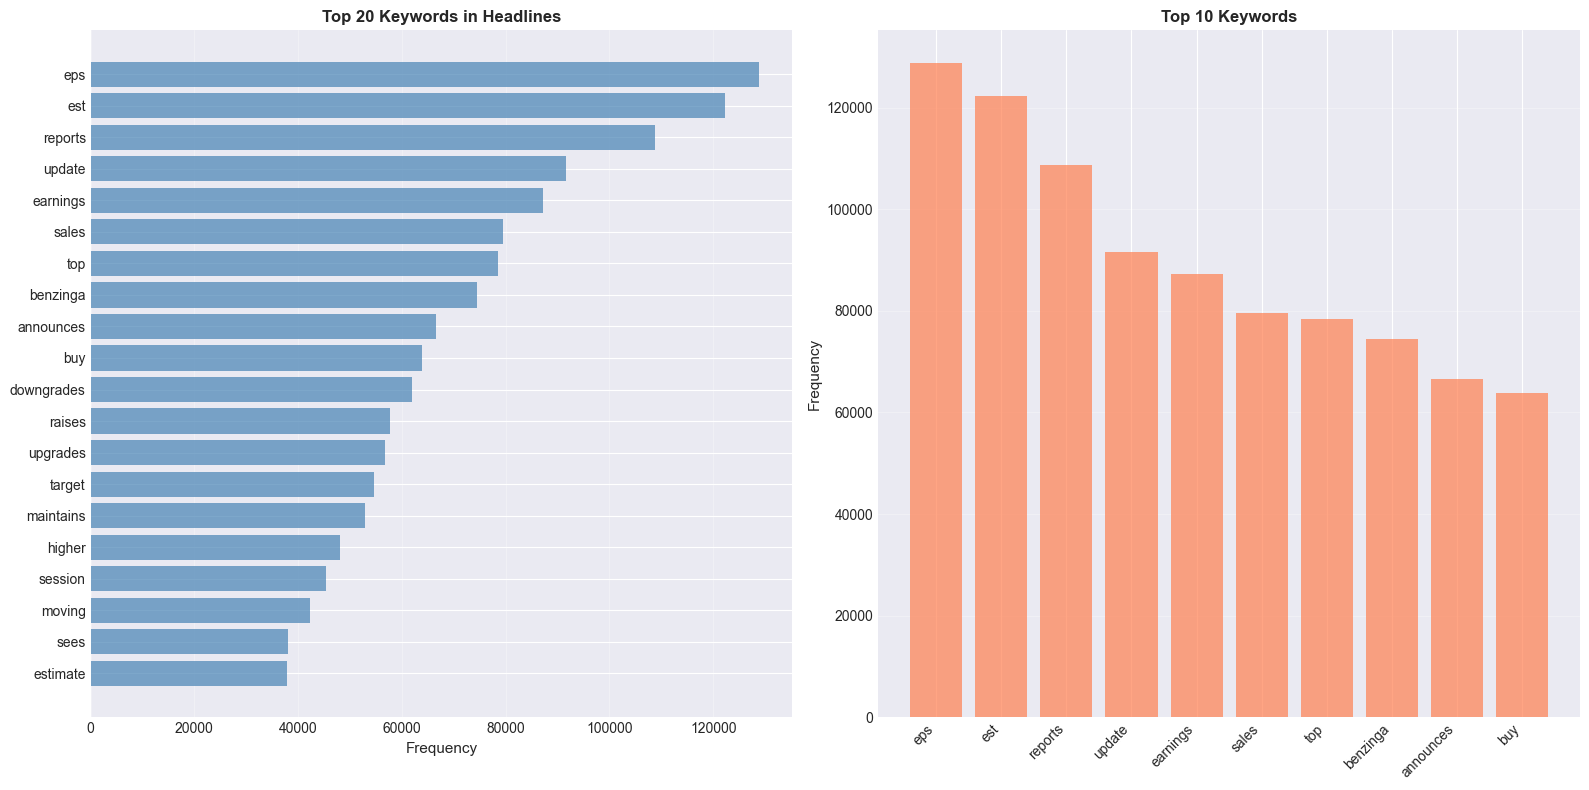

In [36]:
# Visualize top keywords
top_20_words = dict(top_keywords[:20])

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Horizontal bar chart
axes[0].barh(range(len(top_20_words)), list(top_20_words.values()), color='steelblue', alpha=0.7)
axes[0].set_yticks(range(len(top_20_words)))
axes[0].set_yticklabels(list(top_20_words.keys()))
axes[0].set_xlabel('Frequency', fontsize=11)
axes[0].set_title('Top 20 Keywords in Headlines', fontsize=12, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# Top 10 as bar chart
top_10_words = dict(top_keywords[:10])
axes[1].bar(range(len(top_10_words)), list(top_10_words.values()), color='coral', alpha=0.7)
axes[1].set_xticks(range(len(top_10_words)))
axes[1].set_xticklabels(list(top_10_words.keys()), rotation=45, ha='right')
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Top 10 Keywords', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figures/top_keywords.png', dpi=300, bbox_inches='tight')
plt.show()


BIGRAM (TWO-WORD PHRASE) ANALYSIS

Top 20 Bigrams:
reports eps                   :   51,831
eps est                       :   47,900
benzinga top                  :   44,259
earnings scheduled            :   32,054
initiates coverage            :   28,984
sales est                     :   25,319
adj eps                       :   21,709
top upgrades                  :   21,112
option alert                  :   18,226
biggest movers                :   17,806
eps sales                     :   17,626
raises target                 :   16,475
revenue est                   :   16,474
morgan stanley                :   15,811
est revenue                   :   15,538
upgrades downgrades           :   14,839
estimate sales                :   14,397
movers yesterday              :   13,942
lowers target                 :   13,470
analyst blog                  :   13,307


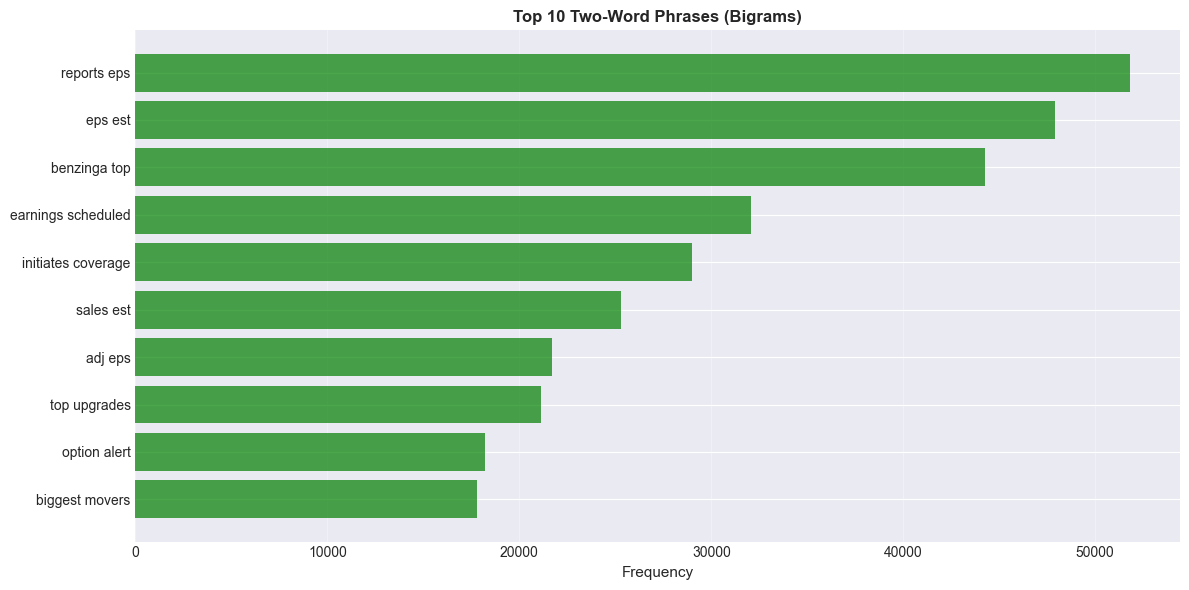

In [37]:
# Analyze bigrams (two-word phrases)
print("="*80)
print("BIGRAM (TWO-WORD PHRASE) ANALYSIS")
print("="*80)

# Create bigrams from filtered tokens
bigrams = []
for i in range(len(filtered_tokens) - 1):
    bigram = f"{filtered_tokens[i]} {filtered_tokens[i+1]}"
    bigrams.append(bigram)

bigram_freq = Counter(bigrams)
top_bigrams = bigram_freq.most_common(20)

print("\nTop 20 Bigrams:")
for phrase, count in top_bigrams:
    print(f"{phrase:30s}: {count:>8,}")

# Visualize top bigrams
top_10_bigrams = dict(top_bigrams[:10])
plt.figure(figsize=(12, 6))
plt.barh(range(len(top_10_bigrams)), list(top_10_bigrams.values()), color='green', alpha=0.7)
plt.yticks(range(len(top_10_bigrams)), list(top_10_bigrams.keys()))
plt.xlabel('Frequency', fontsize=11)
plt.title('Top 10 Two-Word Phrases (Bigrams)', fontsize=12, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('figures/top_bigrams.png', dpi=300, bbox_inches='tight')
plt.show()


## 2.2 Significant Event Detection

**Objective:** Extract significant financial events from headlines using pattern matching.

**Event Types:**
- FDA Approvals
- Price Targets
- Earnings Reports
- Mergers/Acquisitions
- IPOs
- Analyst Ratings
- Stock Splits
- Dividends
- 52-Week High/Low
- Bankruptcy


In [38]:
# Define patterns for significant events
event_patterns = {
    'FDA Approval': r'fda\s+approval|approved\s+by\s+fda|fda\s+approves',
    'Price Target': r'price\s+target|target\s+price|raises\s+price\s+target|lowers\s+price\s+target|price\s+target\s+raised|price\s+target\s+lowered',
    'Earnings': r'earnings|eps|q[1-4]\s+earnings|beats\s+estimate|misses\s+estimate|earnings\s+report|quarterly\s+earnings',
    'Merger/Acquisition': r'merger|acquisition|acquires|acquired|takeover|merges|buyout',
    'IPO': r'ipo|initial\s+public\s+offering|goes\s+public',
    'Analyst Rating': r'upgrade|downgrade|maintains|buy|sell|hold|outperform|underperform|rating\s+upgrade|rating\s+downgrade',
    'Stock Split': r'stock\s+split|split\s+announcement|announces\s+split',
    'Dividend': r'dividend|dividend\s+announcement|dividend\s+increase|dividend\s+payment',
    '52-Week High/Low': r'52-week\s+high|52-week\s+low|hits\s+52-week|reaches\s+52-week',
    'Bankruptcy': r'bankruptcy|files\s+for\s+bankruptcy|chapter\s+\d+|declares\s+bankruptcy'
}

print("="*80)
print("SIGNIFICANT EVENT DETECTION")
print("="*80)
print(f"Defined {len(event_patterns)} event types")
print("\nEvent patterns:")
for event, pattern in event_patterns.items():
    print(f"  • {event}")


SIGNIFICANT EVENT DETECTION
Defined 10 event types

Event patterns:
  • FDA Approval
  • Price Target
  • Earnings
  • Merger/Acquisition
  • IPO
  • Analyst Rating
  • Stock Split
  • Dividend
  • 52-Week High/Low
  • Bankruptcy


In [39]:
# Create event detection columns
print("\nDetecting events in headlines...")
for event_name, pattern in event_patterns.items():
    col_name = f'event_{event_name.lower().replace("/", "_").replace(" ", "_")}'
    df[col_name] = df['headline'].str.contains(pattern, case=False, na=False, regex=True)
    detected = df[col_name].sum()
    print(f"  {event_name}: {detected:,} headlines ({detected/len(df)*100:.2f}%)")

print("\nEvent detection complete!")



Detecting events in headlines...
  FDA Approval: 2,281 headlines (0.16%)
  Price Target: 47,724 headlines (3.39%)
  Earnings: 214,356 headlines (15.23%)
  Merger/Acquisition: 25,662 headlines (1.82%)
  IPO: 8,373 headlines (0.59%)
  Analyst Rating: 263,783 headlines (18.74%)
  Stock Split: 760 headlines (0.05%)
  Dividend: 21,572 headlines (1.53%)
  52-Week High/Low: 49,748 headlines (3.53%)
  Bankruptcy: 882 headlines (0.06%)

Event detection complete!


In [40]:
# Count occurrences of each event type
event_counts = {}
for event_name in event_patterns.keys():
    col_name = f'event_{event_name.lower().replace("/", "_").replace(" ", "_")}'
    event_counts[event_name] = df[col_name].sum()

print("="*80)
print("SIGNIFICANT EVENT COUNTS")
print("="*80)
for event, count in sorted(event_counts.items(), key=lambda x: x[1], reverse=True):
    pct = (count / len(df)) * 100
    print(f"{event:25s}: {count:>8,} ({pct:>5.2f}%)")

# Calculate summary statistics
total_events = sum(event_counts.values())
headlines_with_events = (df[[col for col in df.columns if col.startswith('event_')]].sum(axis=1) > 0).sum()
multiple_events = (df[[col for col in df.columns if col.startswith('event_')]].sum(axis=1) > 1).sum()

print(f"\n" + "="*80)
print("EVENT SUMMARY STATISTICS")
print("="*80)
print(f"Total event detections: {total_events:,}")
print(f"Headlines with at least one event: {headlines_with_events:,} ({headlines_with_events/len(df)*100:.2f}%)")
print(f"Headlines with multiple events: {multiple_events:,} ({multiple_events/len(df)*100:.2f}%)")


SIGNIFICANT EVENT COUNTS
Analyst Rating           :  263,783 (18.74%)
Earnings                 :  214,356 (15.23%)
52-Week High/Low         :   49,748 ( 3.53%)
Price Target             :   47,724 ( 3.39%)
Merger/Acquisition       :   25,662 ( 1.82%)
Dividend                 :   21,572 ( 1.53%)
IPO                      :    8,373 ( 0.59%)
FDA Approval             :    2,281 ( 0.16%)
Bankruptcy               :      882 ( 0.06%)
Stock Split              :      760 ( 0.05%)

EVENT SUMMARY STATISTICS
Total event detections: 635,141
Headlines with at least one event: 583,017 (41.43%)
Headlines with multiple events: 51,490 (3.66%)


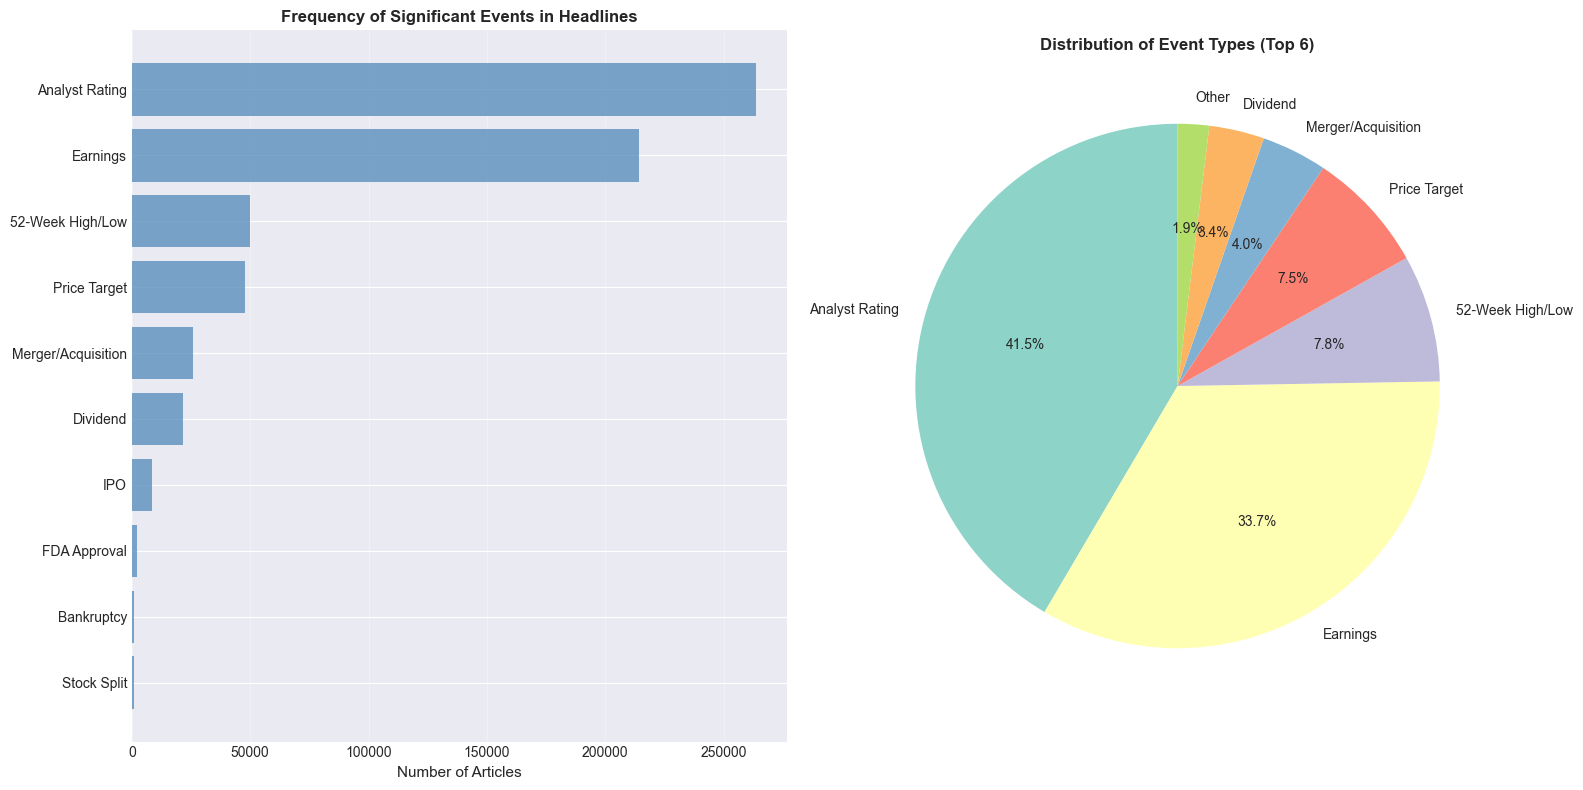

In [41]:
# Visualize event frequencies
events_df = pd.DataFrame(list(event_counts.items()), columns=['Event', 'Count'])
events_df = events_df.sort_values('Count', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Horizontal bar chart
axes[0].barh(events_df['Event'], events_df['Count'], color='steelblue', alpha=0.7)
axes[0].set_xlabel('Number of Articles', fontsize=11)
axes[0].set_title('Frequency of Significant Events in Headlines', fontsize=12, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# Pie chart for top events
top_events = events_df.head(6)  # Top 6 events
other_count = events_df.iloc[6:]['Count'].sum() if len(events_df) > 6 else 0
if other_count > 0:
    top_events = pd.concat([top_events, pd.DataFrame([{'Event': 'Other', 'Count': other_count}])])

axes[1].pie(top_events['Count'], labels=top_events['Event'], autopct='%1.1f%%', 
            startangle=90, colors=plt.cm.Set3.colors)
axes[1].set_title('Distribution of Event Types (Top 6)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('figures/event_frequencies.png', dpi=300, bbox_inches='tight')
plt.show()


## 2.3 Topic Modeling

**Objective:** Use NLP techniques (LDA and NMF) to identify main topics/themes in the headlines.

**Methods:**
- **LDA (Latent Dirichlet Allocation)** - Probabilistic topic model
- **NMF (Non-negative Matrix Factorization)** - Matrix factorization approach

**Note:** For large datasets, we'll use a sample to make topic modeling computationally feasible.


In [42]:
# Sample data for topic modeling (use sample if dataset is too large)
sample_size = min(50000, len(df))
print(f"Dataset size: {len(df):,} headlines")
print(f"Using sample size: {sample_size:,} for topic modeling")

df_sample = df.sample(n=sample_size, random_state=42)

# Prepare text data
headlines = df_sample['headline'].astype(str).tolist()
print(f"\nPrepared {len(headlines):,} headlines for topic modeling")


Dataset size: 1,407,328 headlines
Using sample size: 50,000 for topic modeling

Prepared 50,000 headlines for topic modeling


In [43]:
# Create TF-IDF vectorizer
print("\n" + "="*80)
print("TF-IDF VECTORIZATION")
print("="*80)

vectorizer = TfidfVectorizer(
    max_features=1000,
    stop_words='english',
    ngram_range=(1, 2),  # Include unigrams and bigrams
    min_df=5,  # Word must appear in at least 5 documents
    max_df=0.7,  # Word must appear in less than 70% of documents
    lowercase=True,
    strip_accents='unicode'
)

# Fit and transform
print("Fitting TF-IDF vectorizer...")
tfidf_matrix = vectorizer.fit_transform(headlines)
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
print(f"Vocabulary size: {len(vectorizer.get_feature_names_out()):,}")



TF-IDF VECTORIZATION
Fitting TF-IDF vectorizer...
TF-IDF matrix shape: (50000, 1000)
Vocabulary size: 1,000


In [44]:
# Apply LDA (Latent Dirichlet Allocation)
print("\n" + "="*80)
print("LDA TOPIC MODELING")
print("="*80)

n_topics = 10
print(f"Extracting {n_topics} topics using LDA...")

lda = LatentDirichletAllocation(
    n_components=n_topics, 
    random_state=42, 
    max_iter=10,
    learning_method='batch',
    n_jobs=-1
)

lda.fit(tfidf_matrix)

# Display topics
feature_names = vectorizer.get_feature_names_out()

print("\nIdentified Topics (LDA):")
print("="*80)
for topic_idx, topic in enumerate(lda.components_):
    top_words_idx = topic.argsort()[-10:][::-1]
    top_words = [feature_names[i] for i in top_words_idx]
    top_weights = [topic[i] for i in top_words_idx]
    print(f"\nTopic {topic_idx + 1}:")
    for word, weight in zip(top_words, top_weights):
        print(f"  {word:20s} (weight: {weight:.4f})")



LDA TOPIC MODELING
Extracting 10 topics using LDA...

Identified Topics (LDA):

Topic 1:
  biggest              (weight: 336.9401)
  movers               (weight: 276.7342)
  biggest movers       (weight: 262.2090)
  movers yesterday     (weight: 217.9240)
  yesterday            (weight: 203.9136)
  ceo                  (weight: 177.1444)
  says                 (weight: 152.7435)
  premarket            (weight: 141.9507)
  gainers              (weight: 126.6617)
  losers               (weight: 121.1093)

Topic 2:
  buy                  (weight: 522.8106)
  pt                   (weight: 504.3228)
  initiates            (weight: 355.1332)
  bank                 (weight: 350.0513)
  announces            (weight: 346.4592)
  coverage             (weight: 328.7364)
  00                   (weight: 319.7435)
  raises               (weight: 298.4628)
  initiates coverage   (weight: 295.9812)
  update               (weight: 248.8696)

Topic 3:
  etfs                 (weight: 367.8735)
  etf   

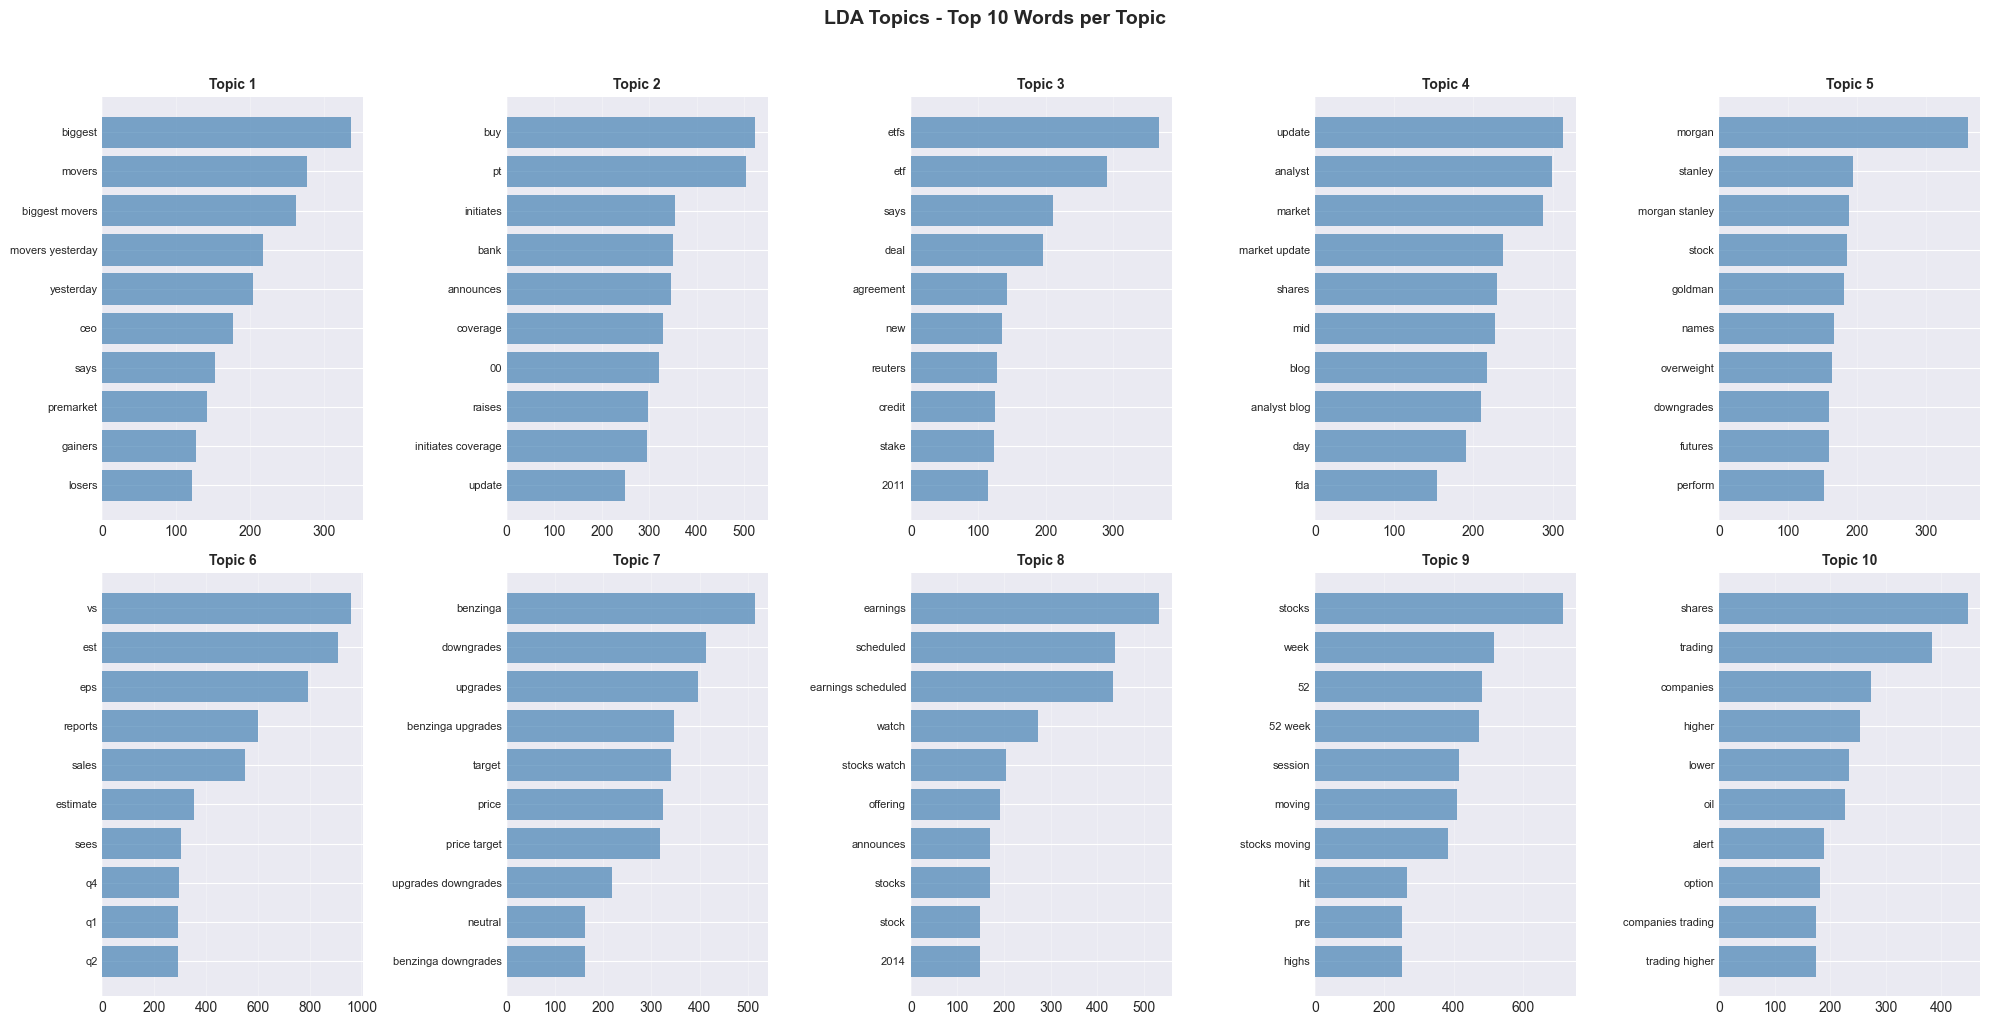

In [45]:
# Visualize LDA topics
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()

for topic_idx, topic in enumerate(lda.components_):
    top_words_idx = topic.argsort()[-10:][::-1]
    top_words = [feature_names[i] for i in top_words_idx]
    top_weights = [topic[i] for i in top_words_idx]
    
    axes[topic_idx].barh(range(len(top_words)), top_weights, color='steelblue', alpha=0.7)
    axes[topic_idx].set_yticks(range(len(top_words)))
    axes[topic_idx].set_yticklabels(top_words, fontsize=8)
    axes[topic_idx].set_title(f'Topic {topic_idx + 1}', fontsize=10, fontweight='bold')
    axes[topic_idx].invert_yaxis()
    axes[topic_idx].grid(True, alpha=0.3, axis='x')

plt.suptitle('LDA Topics - Top 10 Words per Topic', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('figures/lda_topics.png', dpi=300, bbox_inches='tight')
plt.show()


## Summary

This notebook has analyzed:

1. **Keyword and Phrase Extraction:**
   - Identified top keywords and their frequencies
   - Analyzed bigrams (two-word phrases)
   - Created visualizations of most common terms

2. **Significant Event Detection:**
   - Detected 10 types of financial events using pattern matching
   - Calculated event frequencies and distributions
   - Identified headlines with multiple events

3. **Topic Modeling:**
   - Applied LDA (Latent Dirichlet Allocation) to identify topics
   - Applied NMF (Non-negative Matrix Factorization) as alternative approach
   - Visualized topics and their key words
   - Compared topic distributions

**Key Outputs:**
- Event detection columns added to dataframe
- Topic models trained and ready for further analysis
- Visualizations saved to `figures/` directory

**Next Steps:**
- Proceed to `04_Time_Series_Analysis.ipynb` for temporal patterns
- Or continue with `05_Publisher_Analysis.ipynb` for publisher deep dive
- Use event detection results in correlation analysis
